In [46]:
#Necessary import

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from yahoofinancials import YahooFinancials as yf
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, plot_confusion_matrix
from sklearn.preprocessing import StandardScaler
%matplotlib inline

### Data Gathering

In [2]:
# Picking the stock to predict and get historical data

def get_stock_data(tickers, start_date='2020-01-01', end_date='2020-03-31', freq='daily'):
    '''This function takes the list of stock ticker and get historical OHLC data
    
    Parameters
    ----------
    tickers : list/iterable
        Iterable object containing ticker symbols as strings
    start_date : str, optional
        Takes start date of data, format = 'yyyy-mm-dd'
    end_date : str, optional
        Takes ebd date of data, format = 'yyyy-mm-dd'
        
    Returns
    -------
    pandas DataFrame containing pricing data and list containing tickers whose data was not found
    
    '''

    ticker_not_found=[]
    for ticker in tickers:
        yf_engine = yf(ticker)
        price = yf_engine.get_historical_price_data(start_date,end_date,freq)
        #store the data in DataFrame
        try:
            ticker_data = pd.DataFrame(price[ticker]['prices'])
            ticker_data = ticker_data.drop('date', axis=1) # We will use formatted_date columns instead
        except:
            ticker_not_found.append(ticker)
            continue
            
    return ticker_data, ticker_not_found
    


In [3]:
#We will use Google stock ticker to predict its prices
ticker = ['GOOG']
start_date = '2020-01-01'
end_date = '2020-11-30'

df, ticker_not_found = get_stock_data(ticker, start_date, end_date)

df.head()

,high,low,open,close,volume,adjclose,formatted_date
0,1368.140015,1341.550049,1341.550049,1367.369995,1406600,1367.369995,2020-01-02
1,1372.500000,1345.543945,1347.859985,1360.660034,1186400,1360.660034,2020-01-03
2,1396.500000,1350.000000,1350.000000,1394.209961,1732300,1394.209961,2020-01-06
3,1402.989990,1390.380005,1397.939941,1393.339966,1502700,1393.339966,2020-01-07
4,1411.579956,1390.839966,1392.079956,1404.319946,1528000,1404.319946,2020-01-08


### Data cleaning
Check whether there are any nan values and outliers

In [4]:
df.describe()

,high,low,open,close,volume,adjclose
count,230.000000,230.000000,230.000000,230.000000,2.300000e+02,230.000000
mean,1470.265409,1432.732783,1450.310027,1452.366540,1.936283e+06,1452.366540
std,155.874969,160.066582,157.611745,157.004025,7.657950e+05,157.004025
min,1071.319946,1013.536011,1056.510010,1056.619995,8.849000e+05,1056.619995
25%,1397.065002,1354.505005,1379.492523,1386.982513,1.424925e+06,1386.982513
50%,1476.302002,1446.580017,1462.015015,1462.350037,1.693850e+06,1462.350037
75%,1561.837494,1514.112488,1525.930054,1525.522461,2.245750e+06,1525.522461
max,1818.060059,1772.439941,1790.900024,1793.189941,4.329100e+06,1793.189941


In [5]:
df[df.isna()==True].sum().sum()

0.0

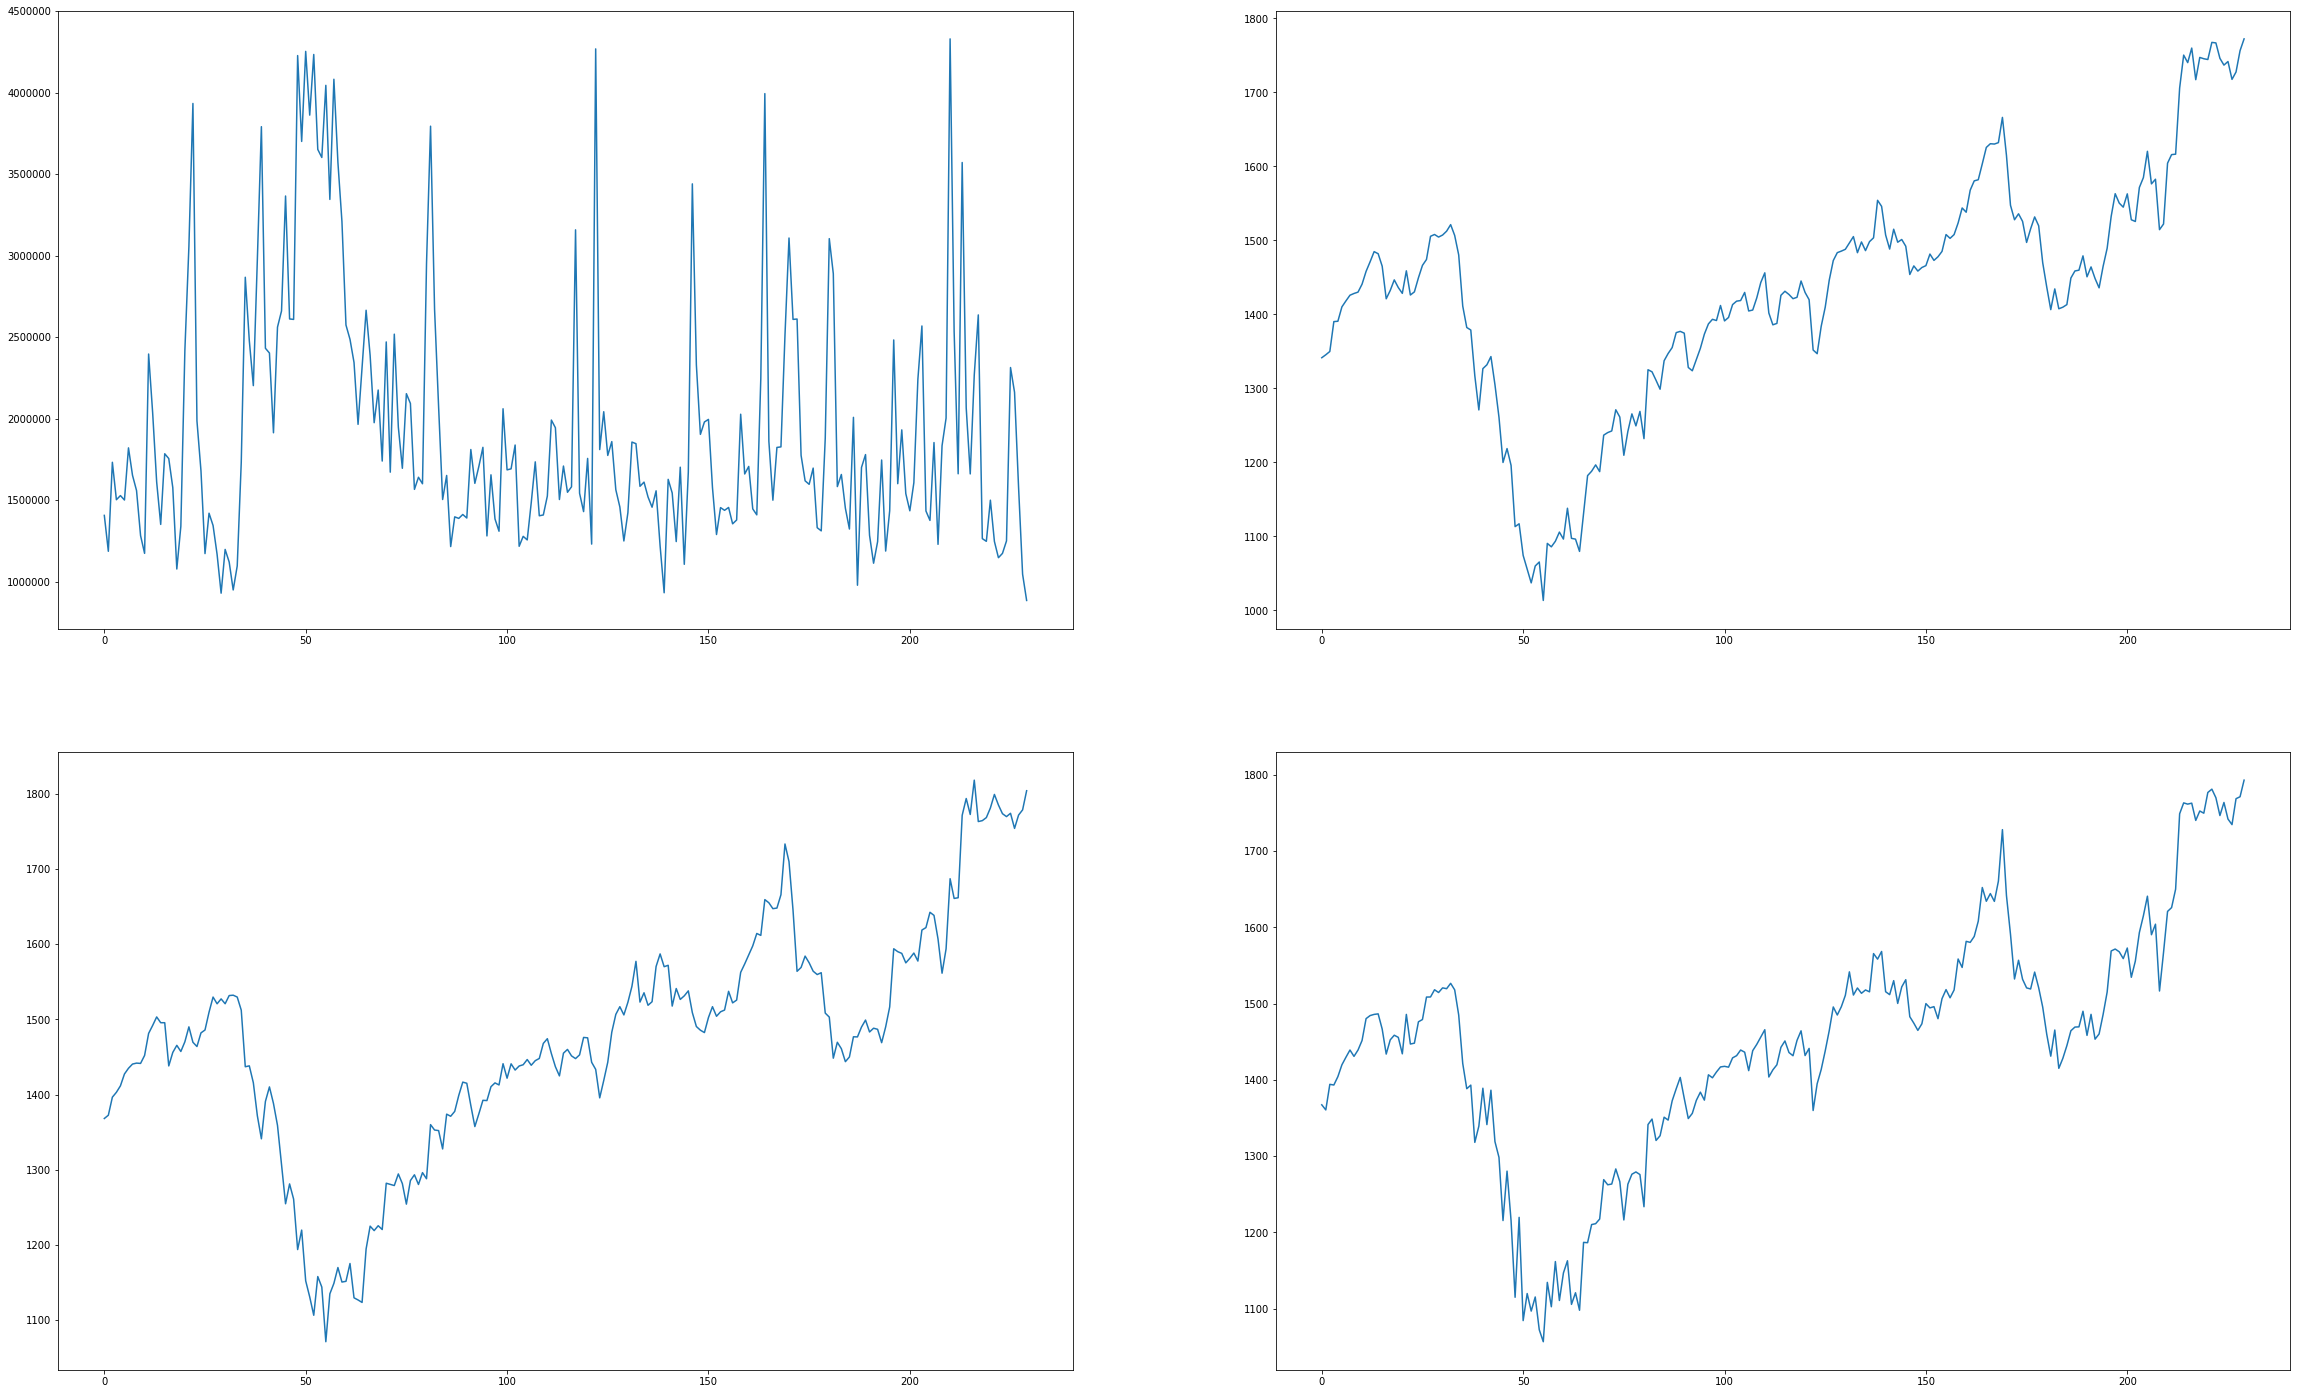

In [6]:
figure, axes = plt.subplots(nrows=2, ncols=2,figsize = [40,25])
axes[0,0].plot(df.volume);
axes[0,1].plot(df.low);
axes[1,0].plot(df.high);
axes[1,1].plot(df.adjclose);

As the mean and median (50%) is not so far off for every column except volume that means there are no outliers and there is no np.nan values in dataframe as well. Please note that high volume is not an outlier and instead in my opinion will serve as unique data point for make prediction for my classifier

### Feature Engineering
We will now create certain features from the pricing data which would include:  
1) SMA_20 : Simple Moving Average of 20 day window  
2) Std_dev : Standard Deviation for 20 day window  
3) Band_1 : Bollinger band created using SMA_20 + Std_dev  
4) Band_2 : Bollinger band created using SMA_20 - Std_dev  
5) ON_returns : whether there was up or down move from prior day closing price to current day opening price   
6) dist_from_mean : How much distant stock prices are from the mean   
7) vix_data: CBOE Volatility index price from the prior day

In [7]:
features = df.copy()
features = features.drop(['formatted_date'], axis=1)
features['SMA'] = features['adjclose'].rolling(window=20).mean().shift(1)
features['Std_20'] = features['adjclose'].rolling(window=20).std().shift(1)
features['Band_1'] = features['SMA'] - features['Std_20']
features['Band_2'] = features['SMA'] + features['Std_20']
features['ON_returns'] = features['close'] - features['open'].shift(-1)
features['ON_returns'] = features['ON_returns'].shift(1)
features['ON_returns_signal'] = np.where(features['ON_returns']<0, 'up', 'down')
features['dist_from_mean'] = features['adjclose'].shift(1) - features['SMA']

In [8]:
#Obtaining Vix Data and combining with existing features of stock
ticker = ['^VIX']
start_date = '2020-01-01'
end_date = '2020-11-30'

vix_data, ticker_not_found = get_stock_data(ticker, start_date, end_date)
vix_data = pd.DataFrame(vix_data['adjclose'].shift(1))
vix_data = vix_data.rename(columns = {'adjclose':'vix_data'})
comb_features = pd.concat([features,vix_data], axis=1)

In [20]:
comb_features.head()

,high,low,open,close,volume,adjclose,SMA,Std_20,Band_1,Band_2,ON_returns,ON_returns_signal,dist_from_mean,vix_data
0,1368.140015,1341.550049,1341.550049,1367.369995,1406600,1367.369995,NaN,NaN,NaN,NaN,NaN,down,NaN,NaN
1,1372.500000,1345.543945,1347.859985,1360.660034,1186400,1360.660034,NaN,NaN,NaN,NaN,19.510010,down,NaN,12.47
2,1396.500000,1350.000000,1350.000000,1394.209961,1732300,1394.209961,NaN,NaN,NaN,NaN,10.660034,down,NaN,14.02
3,1402.989990,1390.380005,1397.939941,1393.339966,1502700,1393.339966,NaN,NaN,NaN,NaN,-3.729980,up,NaN,13.85
4,1411.579956,1390.839966,1392.079956,1404.319946,1528000,1404.319946,NaN,NaN,NaN,NaN,1.260010,down,NaN,13.79


In [22]:
comb_features = comb_features.dropna()
comb_features = pd.get_dummies(comb_features, columns=['ON_returns_signal'])
comb_features = comb_features.drop('ON_returns', axis=1)
comb_features = comb_features.drop('close', axis=1) #not really needed this value since we have adj close now

In [23]:
###Create return column to predict

comb_features['stock_move'] = np.where(comb_features['adjclose']-comb_features['adjclose'].shift(-1)<0, "Buy", "Sell")


In [25]:
comb_features.head()

,high,low,open,volume,adjclose,SMA,Std_20,Band_1,Band_2,dist_from_mean,vix_data,ON_returns_signal_down,ON_returns_signal_up,stock_move
20,1470.130005,1428.530029,1468.900024,2417200,1434.229980,1436.774988,37.724202,1399.050786,1474.499190,19.064978,15.490000,0,1,Buy
21,1490.000000,1458.989990,1462.000000,3055200,1485.939941,1440.117987,34.031800,1406.086187,1474.149787,-5.888007,18.840000,0,1,Sell
22,1469.500000,1426.300049,1457.069946,3933000,1447.069946,1446.381982,29.917814,1416.464168,1476.299797,39.557959,17.969999,1,0,Buy
23,1463.839966,1430.560059,1462.420044,1986200,1448.229980,1449.024982,27.285316,1421.739665,1476.310298,-1.955035,16.049999,0,1,Buy
24,1482.000000,1449.569946,1450.329956,1679400,1476.229980,1451.769482,23.945604,1427.823879,1475.715086,-3.539502,15.150000,0,1,Buy


### Finding correlation using correlation matric

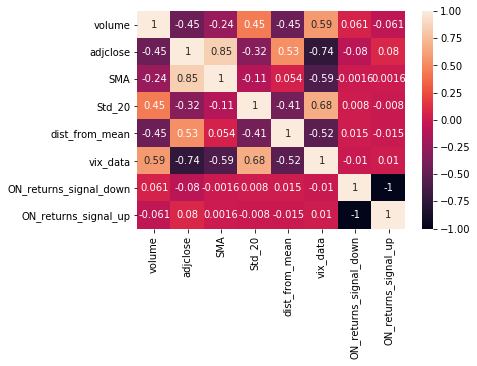

In [48]:
corr_m = comb_features.drop(['high', 'low', 'open','Band_1', 'Band_2'], axis=1).corr()
sn.heatmap(corr_m, annot=True)
plt.show()

Volatility index has strong negative correlation with the stock price (-0.74) and therefore we will use this as a feature for our classification model as well.

In [27]:
#Removing nan values
features_clean = comb_features.dropna()
features_clean = features_clean[:-1] #Drop last row which do not have any stock signal
features_clean.tail()

,high,low,open,volume,adjclose,SMA,Std_20,Band_1,Band_2,dist_from_mean,vix_data,ON_returns_signal_down,ON_returns_signal_up,stock_move
224,1769.589966,1737.005005,1738.380005,1249900,1763.920044,1689.383496,84.534676,1604.848820,1773.918173,57.396533,23.840000,1,0,Sell
225,1774.000000,1741.859985,1765.209961,2313500,1742.189941,1696.813000,84.212744,1612.600257,1781.025744,67.107043,23.110001,0,1,Sell
226,1753.900024,1717.719971,1749.599976,2161600,1734.859985,1701.872498,83.721325,1618.151173,1785.593822,40.317444,23.700001,0,1,Buy
227,1771.599976,1727.689941,1730.500000,1578000,1768.880005,1709.092999,79.738527,1629.354472,1788.831526,25.766986,22.660000,1,0,Buy
228,1778.540039,1756.540039,1772.890015,1045800,1771.430054,1717.323999,76.789516,1640.534483,1794.113515,51.556006,21.639999,0,1,Buy


In [28]:
X = features_clean.drop('stock_move', axis=1)
y = features_clean['stock_move']

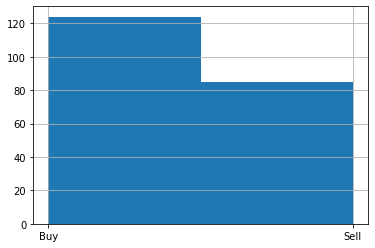

In [29]:
y.hist(bins=2);

Since predictions are somewhat evenly distributed so there is lesser chance of bias in our predictor model. Having "Buy" signals more than sell signal kind of makes sense since Jan, stock price of Google stock has risen. 

### Prediction Classifier

In [30]:
#test train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [33]:
#Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [34]:
#Training the model
classifier = RandomForestClassifier(n_estimators=30, random_state=0)
classifier.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=6,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

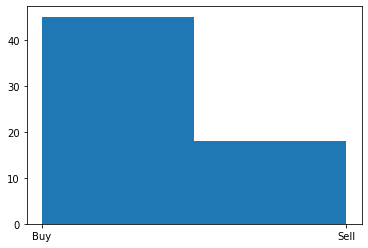

In [35]:
y_pred = classifier.predict(X_test)
plt.hist(y_pred, bins=2);

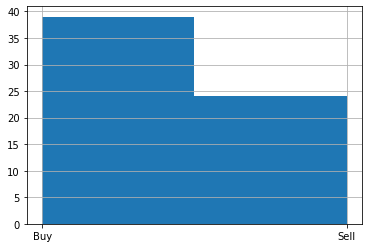

In [36]:
y_test.hist(bins=2);

### Measuring the performance of the model

Accuracy score of the model is:  0.5238095238095238


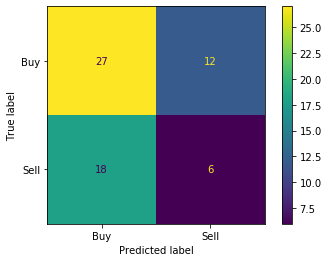

In [37]:
print ("Accuracy score of the model is: ", accuracy_score(y_test, y_pred))
plot_confusion_matrix(classifier, X_test, y_test);

### Tuning Hyperparameters

In [38]:
accuracy ={}
for i in range(1,300):
    classifier = RandomForestClassifier(n_estimators=i, random_state=0)
    classifier.fit(X_train, y_train)
    y_pred_ev = classifier.predict(X_test)
    accuracy[i] = accuracy_score(y_test, y_pred_ev)

In [39]:
max(accuracy.values())

0.6031746031746031

In [40]:
value = max(accuracy.values())
for key, val in accuracy.items():
    if val == value:
        print(key)

30


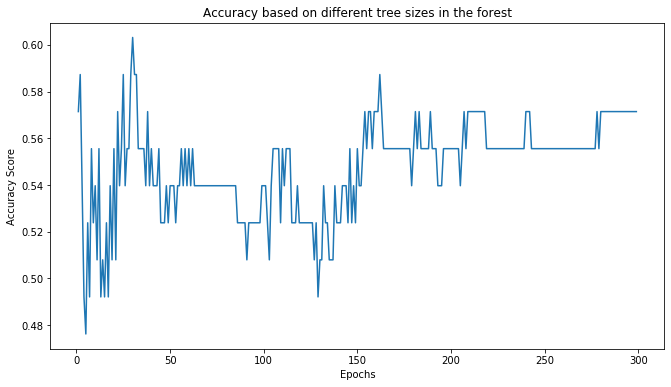

In [41]:
plt.figure(figsize=(11 , 6))
plt.plot(list(accuracy.keys()), list(accuracy.values()))
plt.title('Accuracy based on different tree sizes in the forest')
plt.xlabel('Epochs')
plt.ylabel('Accuracy Score')
plt.show()

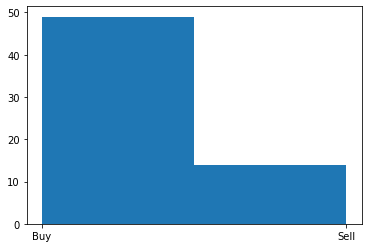

In [42]:
clf = svm.SVC(kernel = 'linear')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
plt.hist(y_pred, bins=2);

Accuracy score of the model is:  0.6190476190476191


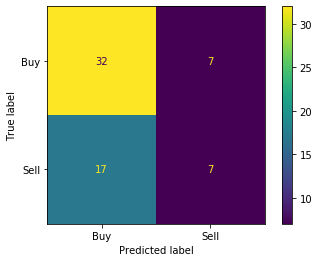

In [43]:
print ("Accuracy score of the model is: ", accuracy_score(y_test, y_pred))
plot_confusion_matrix(clf, X_test, y_test);

### Support Vector Classifier is better predictor of the stock prices.